<h1>Fetching dataset</h1>

<h4>Init info for fetching</h4>

In [3]:
import requests
import os
from concurrent.futures import ThreadPoolExecutor
from dotenv import load_dotenv

load_dotenv()

CAT_API_KEY = os.getenv("CAT_API_KEY")
DOG_API_KEY = os.getenv("DOG_API_KEY")
NUM_IMAGES = 1000
CAT_OUTPUT_DIR = './dataset/cat'
DOG_OUTPUT_DIR = './dataset/dog'

os.makedirs(CAT_OUTPUT_DIR, exist_ok=True)
os.makedirs(DOG_OUTPUT_DIR, exist_ok=True)

<h4>Function for fetching cat images</h4>

In [4]:
def fetch_cat_images(count):
    url = "https://api.thecatapi.com/v1/images/search"
    headers = {"x-api-key": CAT_API_KEY}
    params = {"limit": 30}

    images_downloaded = 0

    while images_downloaded < count:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()

        data = response.json()
        for idx, photo in enumerate(data):
            if images_downloaded >= count:
                break
            image_url = photo["url"]
            
            try:
                image_response = requests.get(image_url)
                image_response.raise_for_status()
                image_filename = os.path.join(CAT_OUTPUT_DIR, f"cat_{images_downloaded}.jpg")
                
                with open(image_filename, 'wb') as f:
                    f.write(image_response.content)
                images_downloaded += 1

                if images_downloaded % 50 == 0:
                    print(f"Downloaded {images_downloaded} cat images.")

            except requests.exceptions.RequestException as e:
                print(f"Failed to download {image_url}: {e}")

<h4>Function for fetching dog images</h4>

In [5]:
def fetch_dog_images(count):
    url = "https://api.thedogapi.com/v1/images/search"
    headers = {"x-api-key": DOG_API_KEY}
    params = {"limit": 30}

    images_downloaded = 0

    while images_downloaded < count:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()

        data = response.json()
        for idx, photo in enumerate(data):
            if images_downloaded >= count:
                break
                
            image_url = photo["url"]
            
            try:
                image_response = requests.get(image_url)
                image_response.raise_for_status()
                image_filename = os.path.join(DOG_OUTPUT_DIR, f"dog_{images_downloaded}.jpg")
                
                with open(image_filename, 'wb') as f:
                    f.write(image_response.content)
                    
                images_downloaded += 1

                if images_downloaded % 50 == 0:
                    print(f"Downloaded {images_downloaded} dog images.")

            except requests.exceptions.RequestException as e:
                print(f"Failed to download {image_url}: {e}")

<h4>Function for concurrent fetching to save time</h4>

In [6]:
def fetch_images_concurrently():
    with ThreadPoolExecutor(max_workers=2) as executor:

        cat_future = executor.submit(fetch_cat_images, NUM_IMAGES)
        dog_future = executor.submit(fetch_dog_images, NUM_IMAGES)

        cat_future.result()
        dog_future.result()

<h4>Actuall fetching (commented out to not start accidentally again)</h4>

In [7]:
#fetch_images_concurrently()

<h1>General imports</h1>

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

<h1>General variables</h1>

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<h1>Transforming images to a better format</h1>

In [10]:
DATASET_DIR = "./dataset"
BATCH_SIZE = 8 #16
VAL_SPLIT = 0.2

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = ImageFolder(DATASET_DIR, transform=transform)
num_val = int(VAL_SPLIT * len(dataset))
num_train = len(dataset) - num_val
train_dataset, val_dataset = random_split(dataset, [num_train, num_val])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

<h1>The model itself</h1>

In [11]:
class MyCnn(nn.Module):
    def __init__(self):
        super(MyCnn, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

<h1>Training function</h1>

In [12]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

<h1>Validation function</h1>

In [13]:
def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

<h1>Training of the model</h1>

In [14]:
# i've done it so that the model learns a bit faster
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)

model = MyCnn().to(DEVICE)

model.apply(init_weights)

LEARNING_RATE = 0.001
EPOCHS = 30

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

writer = SummaryWriter("runs/cat_dog_classification")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)
    writer.add_scalars("Accuracy", {"Train": train_acc, "Validation": val_acc}, epoch)

Epoch 1/30
Train Loss: 1.3743 | Train Acc: 0.6035
Val Loss: 0.9049 | Val Acc: 0.6185
Epoch 2/30
Train Loss: 0.7288 | Train Acc: 0.6515
Val Loss: 0.6044 | Val Acc: 0.6933
Epoch 3/30
Train Loss: 0.5783 | Train Acc: 0.6939
Val Loss: 0.5877 | Val Acc: 0.6908
Epoch 4/30
Train Loss: 0.5603 | Train Acc: 0.7145
Val Loss: 0.5668 | Val Acc: 0.7057
Epoch 5/30
Train Loss: 0.5293 | Train Acc: 0.7382
Val Loss: 0.5497 | Val Acc: 0.7307
Epoch 6/30
Train Loss: 0.4987 | Train Acc: 0.7600
Val Loss: 0.5737 | Val Acc: 0.7357
Epoch 7/30
Train Loss: 0.4343 | Train Acc: 0.7918
Val Loss: 0.6563 | Val Acc: 0.7132
Epoch 8/30
Train Loss: 0.4016 | Train Acc: 0.8217
Val Loss: 0.4889 | Val Acc: 0.7606
Epoch 9/30
Train Loss: 0.3857 | Train Acc: 0.8254
Val Loss: 0.6190 | Val Acc: 0.7182
Epoch 10/30
Train Loss: 0.3650 | Train Acc: 0.8566
Val Loss: 0.6639 | Val Acc: 0.6708
Epoch 11/30
Train Loss: 0.2895 | Train Acc: 0.8791
Val Loss: 0.5404 | Val Acc: 0.7681
Epoch 12/30
Train Loss: 0.2888 | Train Acc: 0.8791
Val Loss: 0.

<h1>Different stats</h1>

Evaluating my cnn model...
Weighted F1 Score: 0.8323200733271022

Classification Report:
               precision    recall  f1-score   support

         cat       0.82      0.88      0.85       212
         dog       0.85      0.78      0.82       189

    accuracy                           0.83       401
   macro avg       0.83      0.83      0.83       401
weighted avg       0.83      0.83      0.83       401



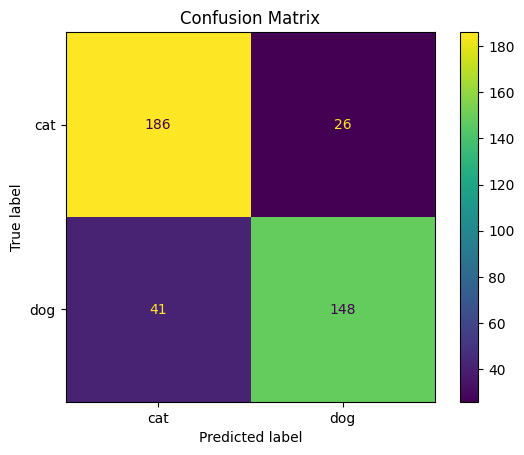

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score

def evaluate_model(model, loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average="weighted")
    cm = confusion_matrix(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, target_names=dataset.classes)

    print("Weighted F1 Score:", f1)
    print("\nClassification Report:\n", report)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap="viridis")
    plt.title("Confusion Matrix")
    plt.show()

print("Evaluating my cnn model...")
evaluate_model(model, val_loader)

<h1>Embedding visualization stuff</h1>

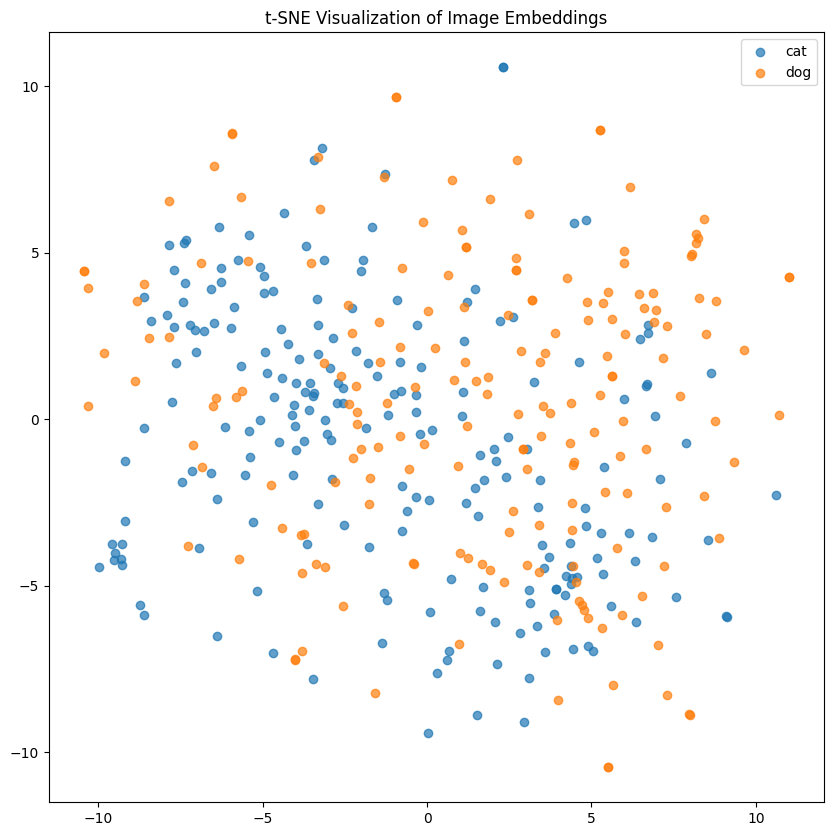

In [16]:
def generate_embeddings(model, loader):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for inputs, label in loader:
            inputs = inputs.to(DEVICE)
            features = model.features(inputs)
            features = features.view(features.size(0), -1)
            embeddings.append(features.cpu().numpy())
            labels.append(label.numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

embeddings, labels = generate_embeddings(model, val_loader)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=dataset.classes[label], alpha=0.7)
plt.legend()
plt.title("t-SNE Visualization of Image Embeddings")
plt.show()

<h1>Transfer learning task</h1>

In [17]:
resnet = resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 2),
)
resnet = resnet.to(DEVICE)

optimizer = optim.Adam(resnet.fc.parameters(), lr=LEARNING_RATE)


for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(resnet, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_epoch(resnet, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS} (Transfer Learning)")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    writer.add_scalars("Transfer Learning Loss", {"Train": train_loss, "Validation": val_loss}, epoch)
    writer.add_scalars("Transfer Learning Accuracy", {"Train": train_acc, "Validation": val_acc}, epoch)

/home/viox/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/viox/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30 (Transfer Learning)
Train Loss: 0.4758 | Train Acc: 0.7830
Val Loss: 0.3436 | Val Acc: 0.8204
Epoch 2/30 (Transfer Learning)
Train Loss: 0.4147 | Train Acc: 0.8192
Val Loss: 0.2713 | Val Acc: 0.8878
Epoch 3/30 (Transfer Learning)
Train Loss: 0.3826 | Train Acc: 0.8267
Val Loss: 0.2634 | Val Acc: 0.8978
Epoch 4/30 (Transfer Learning)
Train Loss: 0.3723 | Train Acc: 0.8292
Val Loss: 0.2873 | Val Acc: 0.8828
Epoch 5/30 (Transfer Learning)
Train Loss: 0.3650 | Train Acc: 0.8473
Val Loss: 0.2645 | Val Acc: 0.8928
Epoch 6/30 (Transfer Learning)
Train Loss: 0.3690 | Train Acc: 0.8373
Val Loss: 0.2621 | Val Acc: 0.9027
Epoch 7/30 (Transfer Learning)
Train Loss: 0.3258 | Train Acc: 0.8579
Val Loss: 0.2473 | Val Acc: 0.8828
Epoch 8/30 (Transfer Learning)
Train Loss: 0.3480 | Train Acc: 0.8566
Val Loss: 0.2625 | Val Acc: 0.8903
Epoch 9/30 (Transfer Learning)
Train Loss: 0.3612 | Train Acc: 0.8485
Val Loss: 0.2209 | Val Acc: 0.9302
Epoch 10/30 (Transfer Learning)
Train Loss: 0.3226 | Tr

Evaluating Transfer Learning Model...
Weighted F1 Score: 0.9250324524293354

Classification Report:
               precision    recall  f1-score   support

         cat       0.91      0.95      0.93       212
         dog       0.94      0.89      0.92       189

    accuracy                           0.93       401
   macro avg       0.93      0.92      0.92       401
weighted avg       0.93      0.93      0.93       401



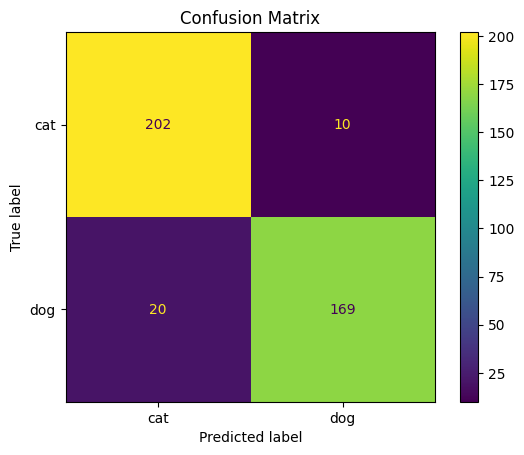

In [18]:
print("Evaluating Transfer Learning Model...")
evaluate_model(resnet, val_loader)